In [ ]:
## Treat larger sequence 

In [8]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [9]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

In [10]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

In [11]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

mu_train, sigma_train = traindf.Return.mean(), traindf.Return.std()
mu_val, sigma_val = validdf.Return.mean(), validdf.Return.std()
mu_test, sigma_test = testdf.Return.mean(), testdf.Return.std()


trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu_train, sigma=sigma_train)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_val, sigma=sigma_val)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_test, sigma=sigma_test)

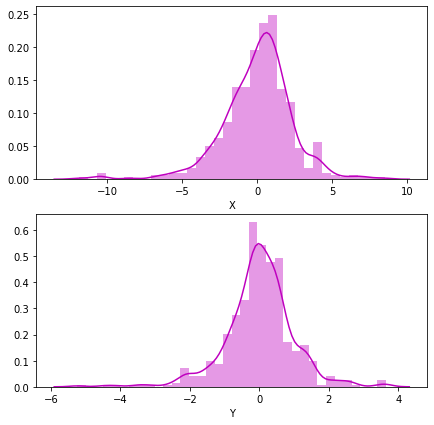

In [5]:
X = []
Y = []
for item in trainloader:
    X.append((torch.sum(item[0])/len(item[0])))
    Y.append(item[1])
normal_df = pd.DataFrame(list(zip(X,Y)), columns= ["X","Y"])

f, axes = plt.subplots(2, 1, figsize=(7, 7))
sns.distplot(normal_df["X"], color="m", ax =axes[0])
sns.distplot(normal_df["Y"], color="m", ax= axes[1])

In [12]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=70, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, dropout=0.25 )

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

LSTM(
  (lstm): LSTM(1, 70, dropout=0.25)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

In [13]:
epochs = 500
loss = []
for i in range(epochs):
    for seq, labels in trainloader:
        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq.squeeze())

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        loss.append(single_loss.item())
        
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.15480018
epoch:  26 loss: 1.58070445
epoch:  51 loss: 1.10141623
epoch:  76 loss: 0.05187020
epoch: 101 loss: 0.05640209
epoch: 126 loss: 0.03015158
epoch: 151 loss: 0.00330640
epoch: 176 loss: 0.01700113
epoch: 201 loss: 0.00068572
epoch: 226 loss: 0.00239025
epoch: 251 loss: 0.00468923
epoch: 276 loss: 0.00100947
epoch: 301 loss: 0.00127943
epoch: 326 loss: 0.00056970
epoch: 351 loss: 0.00098181
epoch: 376 loss: 0.02605418
epoch: 401 loss: 0.00002355
epoch: 426 loss: 0.00429570
epoch: 451 loss: 0.00747053
epoch: 476 loss: 0.01400183
epoch: 499 loss: 0.0025773311


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate(testloader, mu, sigma):

    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = mean_squared_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAE = mean_absolute_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)
    validTheilU = theilU((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RSME : {:.4f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    plt.plot(valid_targets + mu * sigma)
    plt.plot(valid_preds + mu * sigma)

MAE : 0.0061 |  MAPE  : 2.7676 |  RSME : 0.0001 | Theil-U 0.7096


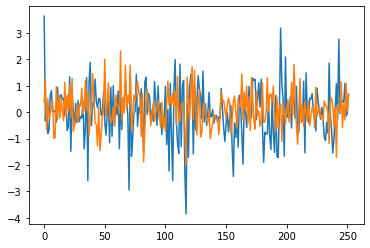

In [21]:
evaluate(validloader, mu_val, sigma_val)


MAE : 0.0068 |  MAPE  : 154.8057 |  RSME : 0.0001 | Theil-U 0.6963


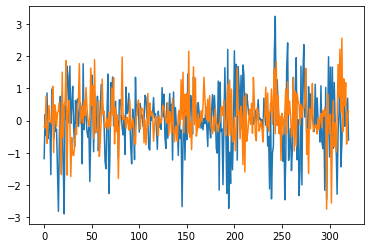

In [22]:
evaluate(testloader, mu_test, sigma_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test


valid_targets = []
valid_preds = []
with torch.no_grad():
    for seq, target in testloader:
        valid_preds.append(model(seq.squeeze()))
        valid_targets += target.numpy().tolist()



validRMSE = mean_squared_error(valid_targets, valid_preds)
validMAE = mean_absolute_error(valid_targets, valid_preds)
validMAPE = mean_absolute_percentage_error(np.array(valid_targets), np.array(valid_preds))
validTheilU = theilU(np.array(valid_targets), np.array(valid_preds))

print("MAE : {:.4f} | MAPE  : {:.4f} | RSME : {:.4f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
        

MAE : 0.8992 | MAPE  : 7.5545 | RSME : 1.3576 | Theil-U 0.6817


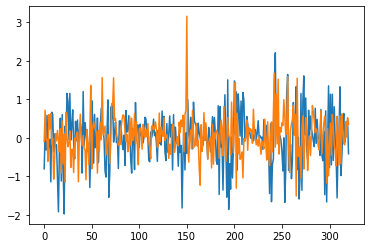

In [19]:
plt.plot(valid_targets)
plt.plot(valid_preds)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test


valid_targets = []
valid_preds = []
with torch.no_grad():
    for seq, target in testloader:
        valid_preds.append(model(seq.squeeze()))
        valid_targets += target.numpy().tolist()



validRMSE = mean_squared_error(valid_targets, valid_preds)
validMAE = mean_absolute_error(valid_targets, valid_preds)
validMAPE = mean_absolute_percentage_error(np.array(valid_targets), np.array(valid_preds))
validTheilU = theilU(np.array(valid_targets), np.array(valid_preds))

print("Valid MAE : {:.4f} | Valid MAPE  : {:.4f} | Valid RSME : {:.4f} | Valid Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
        

Valid MAE : 0.6233 | Valid MAPE  : 3.5624 | Valid RSME : 0.6453 | Valid Theil-U 0.7062
